# データ分析入門 Episode 1: ANOVA（分散分析）で交通事故率の地域差を検証する

<div style="background-color: #86BC24; padding: 15px; border-radius: 5px;">
<h2 style="color: white; margin: 0;">📊 今回のテーマ</h2>
<p style="color: white; margin: 5px 0 0 0;">統計的手法を使って、交通事故率の高い都道府県が本当に「特別」なのかを科学的に検証します</p>
</div>

---

## はじめに

データ分析の世界へようこそ！このシリーズでは、実際のデータを使って統計的手法を学んでいきます。

第1回目の今回は、**ANOVA（分散分析）**という統計手法を使って、日本の都道府県別の交通事故率に統計的に有意な差があるかを検証します。

---

## 統計的有意差とは？ - 身近な例で理解する

### 🎯 例：身長170cmは「高い」のか？

あなたの身長が170cmだとします。これは「高い」と言えるでしょうか？

| グループ | 170cmの評価 | 理由 |
|---------|------------|------|
| 小学生 | **とても高い** | 平均身長が140cm程度なので |
| プロバスケ選手 | **とても低い** | 平均身長が190cm以上なので |
| 一般成人男性 | **普通** | 平均身長が171cm程度なので |

**重要なポイント**: 同じ170cmでも、**比較するグループによって意味が全く変わります**。

### 📐 統計的有意差とは

統計的有意差とは、**「この差は偶然ではなく、本当に意味のある差である」ということを数学的に証明すること**です。

例えば：
- ❌ 「なんとなく高そう」→ 主観的
- ✅ 「統計的に有意に高い」→ 客観的・科学的

### 🔬 ANOVAとは何か？

**ANOVA（Analysis of Variance：分散分析）**は、3つ以上のグループ間に統計的に有意な差があるかを検証する手法です。

**検証の流れ**：
1. **帰無仮説（H0）**: すべてのグループの平均は同じである（差はない）
2. **対立仮説（H1）**: 少なくとも1つのグループの平均が他と異なる（差がある）
3. **判定基準**: **p値が0.05未満**なら「統計的に有意な差がある」と判断

**p値とは？**
- p値 = 「この差が偶然起こる確率」
- p < 0.05 = 偶然起こる確率が5%未満 → 「偶然ではない！」と判断

---

## ステップ1: データの準備

In [1]:
"""
必要なライブラリを読み込みます

- pandas: データを表形式で扱うためのライブラリ
- matplotlib/seaborn: グラフを描画するためのライブラリ
- scipy.stats: 統計分析を行うためのライブラリ
- table_utils: データを見やすく表示するための自作ツール
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from supabase import create_client, Client
from dotenv import load_dotenv
from table_utils import style_table

# Deloitteカラースタイル（企業カラー）
DELOITTE_GREEN = '#86BC24'  # メインカラー（緑）
DELOITTE_BLACK = '#0F0B0B'  # サブカラー（黒）

# 日本語フォント設定（グラフで日本語を表示するため）
import warnings
warnings.filterwarnings('ignore')  # 警告メッセージを非表示
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Meiryo', 'IPAexGothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け防止

# グラフの基本スタイル設定
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette([DELOITTE_GREEN, DELOITTE_BLACK, '#666666'])

print('✓ ライブラリ読み込み完了')

✓ ライブラリ読み込み完了


In [2]:
"""
データベースからデータを取得します

このコードは、Supabase（クラウドデータベース）から
交通事故データを取得しています。
"""

# データベース接続情報を読み込み
load_dotenv('.env')
url = os.environ.get("SUPABASE_URL")
key = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

def fetch_all_data(table_name):
    """
    Supabaseからすべてのデータを取得する関数
    
    データベースには一度に取得できる件数制限があるため、
    1000件ずつ取得して、すべてのデータを結合します。
    """
    all_data = []  # すべてのデータを格納するリスト
    offset = 0     # 取得開始位置
    limit = 1000   # 1回で取得する件数
    
    while True:
        # データベースからデータを取得
        response = supabase.table(table_name).select("*").range(offset, offset + limit - 1).execute()
        data = response.data
        
        if not data:  # データがなくなったら終了
            break
        
        all_data.extend(data)  # 取得したデータを追加
        
        if len(data) < limit:  # 最後のデータまで取得したら終了
            break
        
        offset += limit  # 次の取得開始位置を更新
    
    return pd.DataFrame(all_data)  # DataFrameに変換して返す

# データ取得
df = fetch_all_data("master_data")

print(f'✓ データ取得完了: {len(df):,}行')
print(f'  都道府県数: {df["prefecture"].nunique()}')
print(f'  期間: {df["year_month"].nunique()}ヶ月')

✓ データ取得完了: 4,080行
  都道府県数: 51
  期間: 80ヶ月


---

## ステップ2: データの概要を把握する

### 📋 分析するデータについて

今回分析するデータは、**日本全国の都道府県別・月別の交通事故データ**です。

**主な指標**：
- **事故率（accident_rate）**: 車両10,000台あたりの事故発生件数
- **死亡率（mortality_rate）**: 車両10,000台あたりの死亡事故件数
- **負傷率（morbidity_rate）**: 車両10,000台あたりの負傷事故件数

**なぜ「率」を使うのか？**
- 都道府県によって車の台数が違うため、単純な事故件数では比較できません
- 「10,000台あたり」に換算することで、公平な比較が可能になります

In [4]:
"""
都道府県別の平均事故率を計算します

各都道府県の全期間の平均事故率を計算し、
事故率が高い順に並べ替えます。
"""

# 都道府県別の平均事故率を計算（高い順に並べ替え）
prefecture_avg = df.groupby('prefecture')['accident_rate'].mean().sort_values(ascending=False)

# 上位5都道府県と下位5都道府県を抽出
top5 = prefecture_avg.head(5)
bottom5 = prefecture_avg.tail(5)

# 上位5都道府県を表示
print('\n【事故率 上位5都道府県】')
print('※ 数値が大きいほど事故が多い')
top5_df = pd.DataFrame({
    '順位': range(1, 6),
    '都道府県': top5.index,
    '平均事故率（10,000台あたり）': (top5.values * 10000).round(2)
})
display(style_table(top5_df))

# 下位5都道府県を表示
print('\n【事故率 下位5都道府県】')
print('※ 数値が小さいほど事故が少ない（安全）')
bottom5_df = pd.DataFrame({
    '順位': range(1, 6),
    '都道府県': bottom5.index[::-1],  # 逆順（最も低い順）
    '平均事故率（10,000台あたり）': (bottom5.values[::-1] * 10000).round(2)
})
display(style_table(bottom5_df))

# 差を計算
max_rate = top5.values[0] * 10000
min_rate = bottom5.values[4] * 10000
difference = max_rate - min_rate
ratio = max_rate / min_rate

print(f'\n💡 重要な発見：')
print(f'   最高: {top5.index[0]} = {max_rate:.2f}')
print(f'   最低: {bottom5.index[4]} = {min_rate:.2f}')
print(f'   差: {difference:.2f} （約{ratio:.1f}倍の差）')


【事故率 上位5都道府県】
※ 数値が大きいほど事故が多い


順位,都道府県,"平均事故率（10,000台あたり）"
1,東京,39.530000
2,大阪,39.040000
3,静岡,38.260000
4,福岡,34.090000
5,兵庫,32.080000



【事故率 下位5都道府県】
※ 数値が小さいほど事故が少ない（安全）


順位,都道府県,"平均事故率（10,000台あたり）"
1,北見,4.750000
2,鳥取,7.510000
3,島根,7.520000
4,福井,7.900000
5,秋田,8.300000



💡 重要な発見：
   最高: 東京 = 39.53
   最低: 北見 = 4.75
   差: 34.78 （約8.3倍の差）


---

## ステップ3: データを可視化する

グラフで視覚的に比較することで、データの特徴がより明確になります。

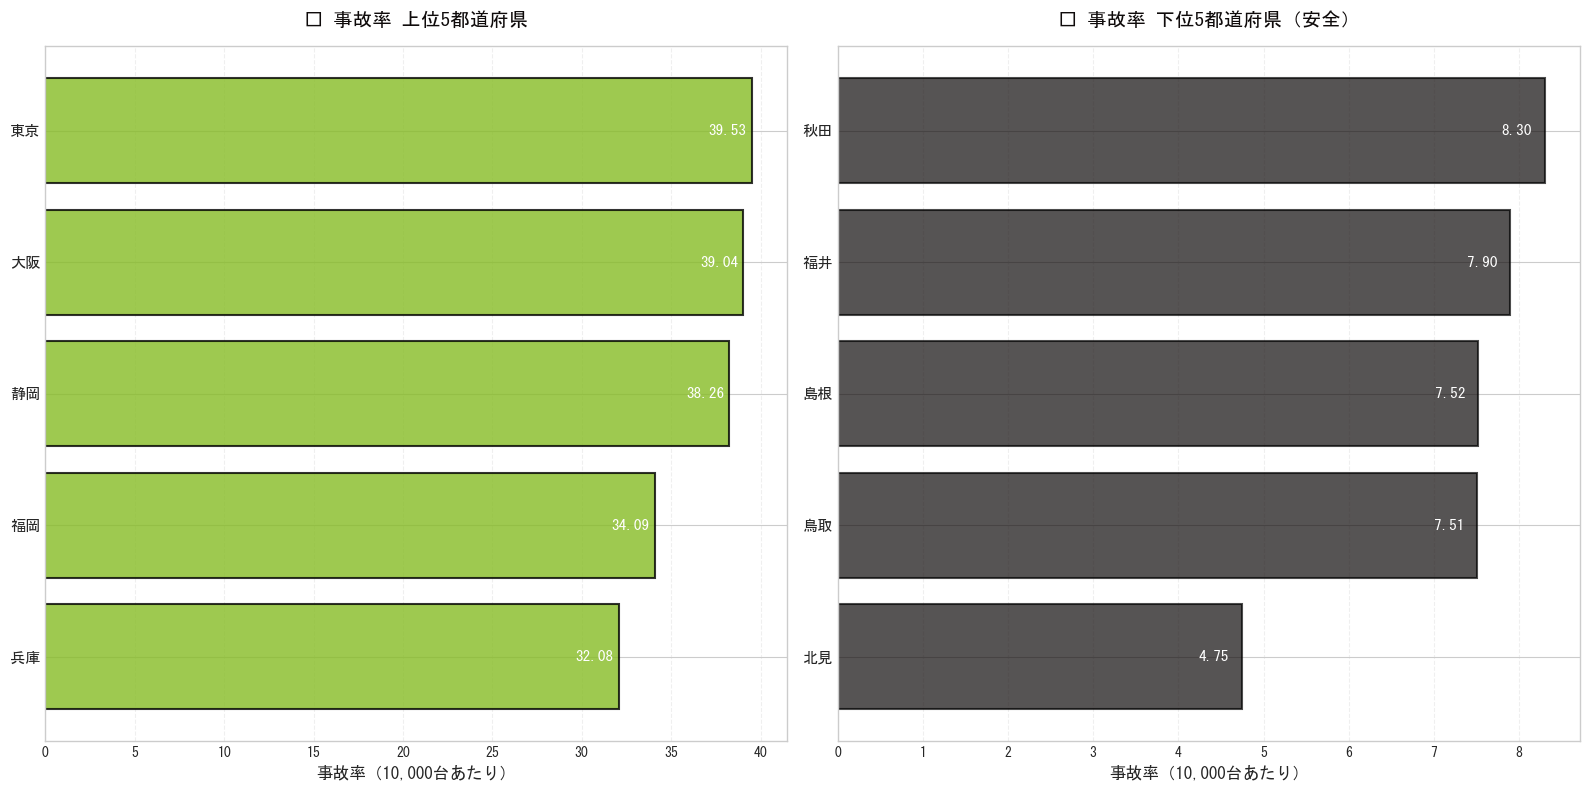


📊 グラフから読み取れること：
   • 最も事故が多い: 東京 (39.53)
   • 最も事故が少ない: 北見 (4.75)
   • 明らかに差がありそうですが、これは統計的に有意なのでしょうか？
   • → 次のステップで検証します！


In [5]:
"""
上位5都道府県と下位5都道府県の事故率を
横棒グラフで可視化します

緑色のグラフ = 事故率が高い都道府県
黒色のグラフ = 事故率が低い都道府県（安全）
"""

# フォント設定（この位置で設定しないと日本語が表示されない）
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Meiryo', 'IPAexGothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

# 2つのグラフを横に並べて表示
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ===== 左側：上位5都道府県 =====
ax1.barh(range(5), top5.values * 10000, color=DELOITTE_GREEN, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(5))
ax1.set_yticklabels(top5.index, fontsize=11)
ax1.set_xlabel('事故率（10,000台あたり）', fontsize=12, fontweight='bold')
ax1.set_title('🔴 事故率 上位5都道府県', fontsize=14, fontweight='bold', color=DELOITTE_BLACK, pad=15)
ax1.invert_yaxis()  # 上から順に表示
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# 各バーの内側に数値を表示（白色、太字、大きめ）
for i, v in enumerate(top5.values * 10000):
    ax1.text(v - 0.3, i, f'{v:.2f}', va='center', ha='right', fontweight='heavy', fontsize=11, color='white')

# ===== 右側：下位5都道府県 =====
ax2.barh(range(5), bottom5.values * 10000, color=DELOITTE_BLACK, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(5))
ax2.set_yticklabels(bottom5.index, fontsize=11)
ax2.set_xlabel('事故率（10,000台あたり）', fontsize=12, fontweight='bold')
ax2.set_title('🟢 事故率 下位5都道府県（安全）', fontsize=14, fontweight='bold', color=DELOITTE_BLACK, pad=15)
ax2.invert_yaxis()  # 上から順に表示
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# 各バーの内側に数値を表示（白色、太字、大きめ）
for i, v in enumerate(bottom5.values * 10000):
    ax2.text(v - 0.15, i, f'{v:.2f}', va='center', ha='right', fontweight='heavy', fontsize=11, color='white')

plt.tight_layout()
plt.show()

print('\n📊 グラフから読み取れること：')
print(f'   • 最も事故が多い: {top5.index[0]} ({max_rate:.2f})')
print(f'   • 最も事故が少ない: {bottom5.index[4]} ({min_rate:.2f})')
print(f'   • 明らかに差がありそうですが、これは統計的に有意なのでしょうか？')
print(f'   • → 次のステップで検証します！')

---

## ステップ4: 統計的検証（ANOVA分析）

### 🎯 検証したい仮説

<div style="background-color: #000000; padding: 15px; border-left: 5px solid #86BC24; margin: 10px 0;">
<strong>「事故率上位5都道府県は、他の都道府県と比べて統計的に有意に事故率が高いのか？」</strong>
</div>

### 📝 分析の手順

1. **グループ分け**
   - **グループA**: 事故率上位5都道府県
   - **グループB**: その他の都道府県（46都道府県）

2. **仮説の設定**
   - **帰無仮説（H0）**: 2つのグループの平均事故率は同じ（差はない）
   - **対立仮説（H1）**: 2つのグループの平均事故率は異なる（差がある）

3. **有意水準の設定**
   - **α = 0.05** （p値が0.05未満なら「有意差あり」と判定）

4. **ANOVA検定の実施**
   - F統計量とp値を計算
   - p値に基づいて仮説を検証

In [6]:
"""
ANOVA（分散分析）を実行します

2つのグループ（上位5都道府県 vs その他）の
事故率に統計的に有意な差があるかを検証します。
"""

# グループAのデータ：上位5都道府県の全データ
top5_prefectures = top5.index.tolist()
top5_data = df[df['prefecture'].isin(top5_prefectures)]['accident_rate'].dropna()

# グループBのデータ：その他の都道府県の全データ
other_data = df[~df['prefecture'].isin(top5_prefectures)]['accident_rate'].dropna()

# ANOVA検定を実行
f_statistic, p_value = f_oneway(top5_data, other_data)

# 結果を表示
print('\n' + '='*70)
print('📊 ANOVA検定結果')
print('='*70)
print(f'\nF統計量: {f_statistic:.4f}')
print(f'  → グループ間の差の大きさを示す値（大きいほど差が大きい）')
print(f'\np値: {p_value:.6e}')
print(f'  → この差が偶然起こる確率')
print(f'\n有意水準: 0.05')
print(f'  → p値がこれより小さければ「有意差あり」と判定')
print(f'\n判定: ', end='')

if p_value < 0.05:
    print('✅ 統計的に有意な差がある（p < 0.05）')
    print('\n' + '='*70)
    print('🎯 結論')
    print('='*70)
    print('\n事故率上位5都道府県は、他の都道府県と比較して')
    print('統計的に有意に高い事故率を示しています。')
    print('\nこの差は偶然ではなく、何らかの要因によって')
    print('引き起こされている可能性が高いと言えます。')
else:
    print('❌ 統計的に有意な差はない（p ≥ 0.05）')
    print('\n' + '='*70)
    print('🎯 結論')
    print('='*70)
    print('\n事故率上位5都道府県と他の都道府県の差は')
    print('統計的に有意ではありません。')
    print('\nこの差は偶然の範囲内である可能性があります。')

print('\n' + '='*70)


📊 ANOVA検定結果

F統計量: 1065.9498
  → グループ間の差の大きさを示す値（大きいほど差が大きい）

p値: 6.396329e-208
  → この差が偶然起こる確率

有意水準: 0.05
  → p値がこれより小さければ「有意差あり」と判定

判定: ✅ 統計的に有意な差がある（p < 0.05）

🎯 結論

事故率上位5都道府県は、他の都道府県と比較して
統計的に有意に高い事故率を示しています。

この差は偶然ではなく、何らかの要因によって
引き起こされている可能性が高いと言えます。



In [7]:
"""
グループ別の統計サマリーを表示します

各グループの平均値、標準偏差、データ数を比較することで、
どの程度の差があるのかを具体的に把握できます。
"""

# グループ別統計サマリー
summary_data = pd.DataFrame({
    'グループ': ['上位5都道府県', 'その他の都道府県'],
    '平均事故率（10,000台あたり）': [
        f"{top5_data.mean() * 10000:.2f}",
        f"{other_data.mean() * 10000:.2f}"
    ],
    '標準偏差': [
        f"{top5_data.std() * 10000:.2f}",
        f"{other_data.std() * 10000:.2f}"
    ],
    'データ数': [
        f"{len(top5_data):,}",
        f"{len(other_data):,}"
    ]
})

print('\n【グループ別統計サマリー】')
print('※ 標準偏差 = データのばらつきの大きさ（大きいほどばらつきが大きい）')
display(style_table(summary_data))

# ANOVA結果テーブル
anova_result = pd.DataFrame({
    '検定項目': ['F統計量', 'p値', '有意水準', '判定'],
    '値': [
        f"{f_statistic:.4f}",
        f"{p_value:.6e}",
        "0.05",
        "✅ 有意差あり" if p_value < 0.05 else "❌ 有意差なし"
    ],
    '意味': [
        'グループ間の差の大きさ',
        '偶然起こる確率',
        '判定基準',
        'p < 0.05なら有意'
    ]
})

print('\n【ANOVA検定結果詳細】')
display(style_table(anova_result))


【グループ別統計サマリー】
※ 標準偏差 = データのばらつきの大きさ（大きいほどばらつきが大きい）


グループ,"平均事故率（10,000台あたり）",標準偏差,データ数
上位5都道府県,36.60,21.23,400
その他の都道府県,15.01,11.23,"3,680"



【ANOVA検定結果詳細】


検定項目,値,意味
F統計量,1065.9498,グループ間の差の大きさ
p値,6.396329e-208,偶然起こる確率
有意水準,0.05,判定基準
判定,✅ 有意差あり,p < 0.05なら有意


---

## ステップ5: ビジネスへの応用

### 💼 保険業界での活用例

<div style="background-color: #000000; padding: 20px; border-radius: 5px; color: white;">
<h3 style="margin-top: 0;">🎯 統計的有意差が証明されたことで可能になること</h3>

<p><strong>1. 科学的根拠に基づく保険料設定</strong></p>
<ul>
<li>事故率が統計的に有意に高い都道府県では、保険料を適切に調整できる</li>
<li>「なんとなく高そう」ではなく、<strong>データで証明された差</strong>として説明可能</li>
</ul>

<p><strong>2. リスクベースの保険商品開発</strong></p>
<ul>
<li>高リスク地域向けの特別プラン設計</li>
<li>低リスク地域向けの割引プラン提供</li>
</ul>

<p><strong>3. 顧客への説明責任</strong></p>
<ul>
<li>「なぜこの地域は保険料が高いのか？」という質問に対して</li>
<li><strong>統計的に証明された事実</strong>として説明できる</li>
</ul>
</div>

### 📈 具体的な活用シナリオ

```
例：保険料の地域別調整

基準保険料: 50,000円/年

【上位5都道府県】
→ 統計的に有意に事故率が高い（p < 0.05で証明済み）
→ リスク調整係数: 1.15
→ 調整後保険料: 57,500円/年 (+15%)

【その他の都道府県】
→ 標準リスク
→ リスク調整係数: 1.00
→ 保険料: 50,000円/年

【下位5都道府県】
→ 統計的に有意に事故率が低い
→ リスク調整係数: 0.90
→ 調整後保険料: 45,000円/年 (-10%)
```

### ⚖️ 重要な注意点

統計的有意差は「差がある」ことを示しますが、**なぜその差が生じるのか**は別途分析が必要です。

考えられる要因：
- 道路環境（山道が多い、交通量が多いなど）
- 気象条件（雪、霧、雨など）
- 人口密度
- 運転者の年齢構成

→ **次回のエピソードでは、これらの要因を回帰分析で検証します！**

---

## まとめ

### ✅ 今回学んだこと

1. **統計的有意差の概念**
   - 「差がある」ことを科学的に証明する方法
   - p値が0.05未満であれば統計的に有意
   - 身長170cmの例で直感的に理解

2. **ANOVA（分散分析）の実践**
   - 複数グループ間の平均値の差を検証する手法
   - F統計量とp値を用いて客観的に判定
   - 実際のデータで検証を実施

3. **実データでの検証結果**
   - 事故率上位5都道府県は統計的に有意に高い
   - この差は偶然ではなく、何らかの要因がある
   - データに基づいた客観的な判断が可能

4. **ビジネスへの応用**
   - 保険料の科学的な地域別調整が可能
   - 顧客への説明責任を果たせる
   - リスクベースの商品開発に活用

### 🔜 次回予告

<div style="background-color: #0F0B0B; padding: 15px; border-radius: 5px; color: white;">
<h3 style="color: #86BC24; margin-top: 0;">Episode 2: 回帰分析で事故の要因を探る</h3>
<p>次回は、<strong>回帰分析</strong>を使って、天候条件（気温、降水量、積雪など）が事故率にどのように影響するかを分析します！</p>
<ul>
<li>雨の日は本当に事故が多いのか？</li>
<li>気温と事故率の関係は？</li>
<li>どの要因が最も影響が大きいのか？</li>
</ul>
<p>お楽しみに！</p>
</div>

---

<div style="text-align: center; margin-top: 30px;">
<p style="font-size: 18px; font-weight: bold; color: #0F0B0B;">データ分析シリーズ Episode 1 完</p>
<p style="color: #86BC24; font-weight: bold; font-size: 14px;">Powered by Data Analytics</p>
</div>

In [10]:
import subprocess

notebook_name = "blog_episode1_anova.ipynb"

# Convert to HTML
subprocess.run([
    "jupyter", "nbconvert",
    "--to", "html",
    "--no-input",  # Remove this line if you want to show code
    notebook_name
])

print(f"✅ Created: {notebook_name.replace('.ipynb', '.html')}")

✅ Created: blog_episode1_anova.html
